In [6]:
#from helper import IMAGE_RES
IMAGE_RES = 100

In [7]:
import os
import json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
)
from keras_tuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [8]:
# training

# define the subdirectory where you training data is located
training_sub = "data/train"
testing_sub = "data/test"

training_path = "/kaggle/input/fer2013/train"
validation_path = "/kaggle/input/fer2013/test"


In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,  #normalize pixel values to be between 0 and 1
    #horizontal_flip=True,  #randomly flip images horizontally
    #validation_split=0.3 # set data split
)

target_size = (IMAGE_RES, IMAGE_RES)  
batch_size = 32

In [10]:
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical", 
    #subset="training", 
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical", 
    #subset="validation",  #
)

class_names = os.listdir(training_path)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
num_rows = 3  
num_cols = (len(class_names) + num_rows - 1) // num_rows

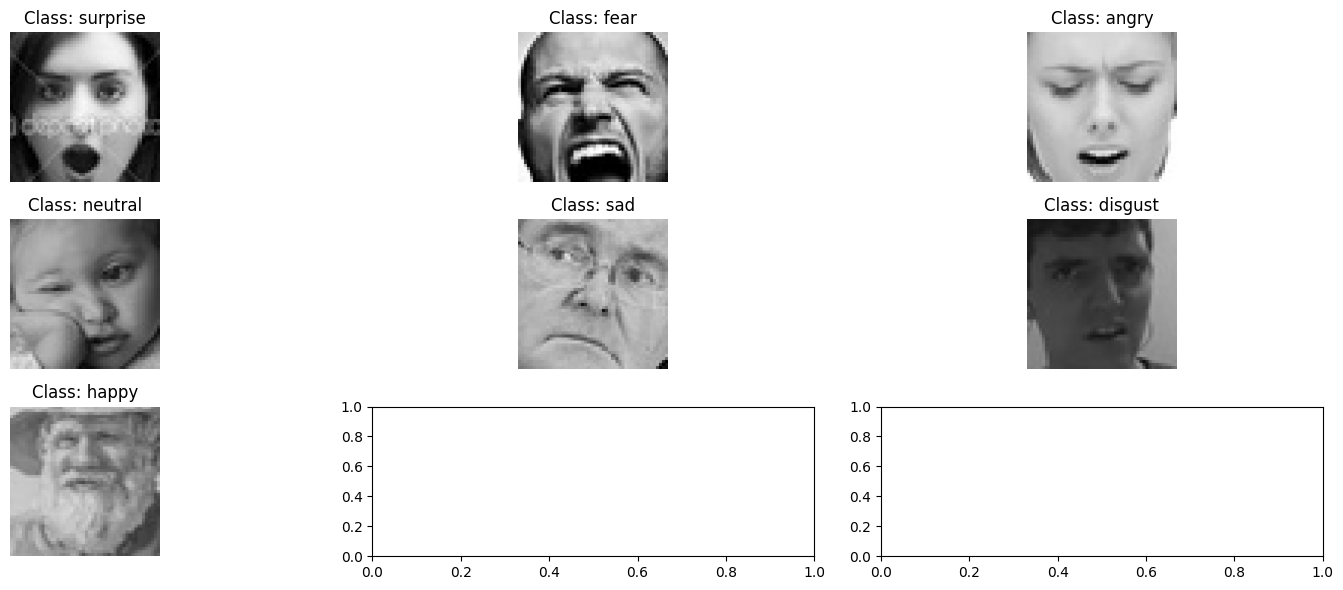

In [12]:
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6))


for i, class_name in enumerate(class_names):
    class_path = os.path.join(training_path, class_name)

    image_files = [
        f for f in os.listdir(class_path) if f.endswith(".jpg") or f.endswith(".png")
    ]

    img_path = os.path.join(class_path, image_files[0])
    img = image.load_img(img_path, target_size=target_size)
    axs[i // num_cols, i % num_cols].imshow(img)
    axs[i // num_cols, i % num_cols].set_title(f"Class: {class_name}")
    axs[i // num_cols, i % num_cols].axis("off")


plt.tight_layout()


plt.show()

In [13]:
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
file_name = "data_lookup_train.json"

with open(file_name, "w") as json_file:
    json.dump(class_indices, json_file)


print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_validation_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class indices: {class_indices}")

Number of training samples: 28709
Number of validation samples: 7178
Number of classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [14]:
def build_model(hp):
    model = keras.Sequential()

    num_conv_layers = hp.Int("num_conv_layers", min_value=1, max_value=5)
    num_dense_layers = hp.Int("num_dense_layers", min_value=1, max_value=3)

    model.add(
        Conv2D(
            filters=hp.Int("conv_1_filter", min_value=4, max_value=256, step=4),
            kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
            activation="relu",
            input_shape=(IMAGE_RES, IMAGE_RES, 3),
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    for i in range(num_conv_layers - 1):  # Adjust range for excluding first layer
        model.add(
            Conv2D(
                filters=hp.Int(
                    f"conv_{i+2}_filter", min_value=4, max_value=256, step=4
                ),
                kernel_size=hp.Choice(f"conv_{i+2}_kernel", values=[3, 5]),
                activation="relu",
            )
        )
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    for i in range(num_dense_layers):
        model.add(
            Dense(
                units=hp.Int(f"dense_{i+1}_units", min_value=1, max_value=150, step=4),
                activation="relu",
            )
        )
        model.add(
            Dropout(
                rate=hp.Float(f"dropout_{i+1}", min_value=0.2, max_value=0.5, step=0.1)
            )
        )

    # Output layer
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [15]:
tuner = Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=2,
    directory="search",
    project_name="emotion_detection",
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:


# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1


early_stopping = EarlyStopping(patience=8, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)


tuner.search(
    train_generator,
    epochs=15,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks=[lr_schedule,early_stopping],
)




Trial 43 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.699999988079071
Total elapsed time: 01h 03m 33s


In [17]:
tuner.search_space_summary()

Search space summary
Default search space size: 19
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 256, 'step': 4, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 150, 'step': 4, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 256, 'step': 4, 'sampling': 'linear'}
conv_2_

In [18]:
tuner.results_summary()

Results summary
Results in search/emotion_detection
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0038 summary
Hyperparameters:
num_conv_layers: 5
num_dense_layers: 1
conv_1_filter: 12
conv_1_kernel: 5
dense_1_units: 93
dropout_1: 0.30000000000000004
learning_rate: 0.001
conv_2_filter: 212
conv_2_kernel: 5
dense_2_units: 13
dropout_2: 0.4
dense_3_units: 117
dropout_3: 0.30000000000000004
conv_3_filter: 12
conv_3_kernel: 3
conv_4_filter: 248
conv_4_kernel: 3
conv_5_filter: 124
conv_5_kernel: 3
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.699999988079071

Trial 0018 summary
Hyperparameters:
num_conv_layers: 3
num_dense_layers: 3
conv_1_filter: 44
conv_1_kernel: 3
dense_1_units: 29
dropout_1: 0.4
learning_rate: 1e-05
conv_2_filter: 152
conv_2_kernel: 5
dense_2_units: 53
dropout_2: 0.30000000000000004
dense_3_units: 145
dropout_3: 0.4
conv_3_filter: 148
conv_3_kernel: 3
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket

In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.values} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
"""
)


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {'num_conv_layers': 5, 'num_dense_layers': 1, 'conv_1_filter': 12, 'conv_1_kernel': 5, 'dense_1_units': 93, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.001, 'conv_2_filter': 212, 'conv_2_kernel': 5, 'dense_2_units': 13, 'dropout_2': 0.4, 'dense_3_units': 117, 'dropout_3': 0.30000000000000004, 'conv_3_filter': 12, 'conv_3_kernel': 3, 'conv_4_filter': 248, 'conv_4_kernel': 3, 'conv_5_filter': 124, 'conv_5_kernel': 3, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0} and the optimal learning rate for the optimizer
is 0.001.



In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 12)     │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 212)    │        63,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 44, 44, 212)    │           848 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 212)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 12)     │        22,908 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 248)      │        27,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 248)      │           992 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 248)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 124)      │       276,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 124)      │           496 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 124)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 93)             │        11,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 93)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           658 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,271 (1.55 MB)

 Trainable params: 405,055 (1.55 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [22]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_schedule, early_stopping],
)

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - accuracy: 0.3111 - loss: 1.7809 - val_accuracy: 0.4370 - val_loss: 1.4658 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.4815 - loss: 1.3540 - val_accuracy: 0.4955 - val_loss: 1.3237 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.5417 - loss: 1.2109 - val_accuracy: 0.4009 - val_loss: 1.5637 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.5755 - loss: 1.1305 - val_accuracy: 0.5451 - val_loss: 1.1967 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.6058 - loss: 1.0411 - val_accuracy: 0.5507 - val_loss: 1.1968 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.6425 - loss: 0.9434 - val_accuracy: 0.5386 - val_loss: 1.2809 - learning_rate: 0.0010
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.6771 - l